<center>
<img src="https://drive.google.com/uc?id=1f1gGVI-rxcHjA90WEGNvvtSXF1pAxQwg" alt="Fasilkom UI" width="300"/>

Tutorial 2

Natanael Pascal Simbolon

2106751764

CSIE604284 • Analitika Media Sosial

Semester Gasal 2025/2026

Fakultas Ilmu Komputer, Universitas Indonesia



# Bagian 2: Text Classification dengan Dataset Publik

Pada bagian ini, saya diminta untuk membangun pipeline text classification lengkap, mulai
dari eksplorasi data, preprocessing, ekstraksi fitur, pelatihan model, hingga evaluasi. Berbeda
dengan Bagian 1 yang menggunakan pretrained model, di sini saya harus melatih model
sendiri dengan dataset publik.

## 1. Pemilihan Dataset Text Classification

Saya akan memilih dataset publik text classification yang memenuhi kriteria:
- Sumbernya dari Kaggle,
- Datasetnya bahasa Indonesia

Dataset yang saya pilih adalah dataset Tokopedia Product Reviews yang detailnya tedapat pada **dataset_info.txt**

# Package Installation

In [ ]:
!pip install requests beautifulsoup4 pandas
!pip install bertopic
!pip install transformers
%pip install Sastrawi


# 2. EDA
Pada bagian ini saya akan melakukan : 
- Analisis Distribusi kelas dengan **bar chart*,
- Staistik panjang teks dengan **histogram*,
- Frekuensi top 20 kata.

In [ ]:
import pandas as pd

In [3]:
df = pd.read_csv("tokopedia-product-reviews-2019.csv")
df.head(3)

,Unnamed: 0,text,rating,category,product_name,product_id,sold,shop_id,product_url
0,1,Barang sesuai pesanan dan cepat sampai,5,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,418660637,1,1740837,https://www.tokopedia.com/shakaonline87/staple...
1,2,Barang bagus harga murah,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
2,3,Paket rapi...mantap....cepat....sampe ke tujuan,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...


## Analisis distribusi kelas (bar chart)
Dapat dilihat bahwa dataset review produk Tokopedia ini memiliki distribusi kategori produk dimana kategori terbanyak adalah elektronik yang diikuti fashion, olahraga, handphone, dan pertukangan. 

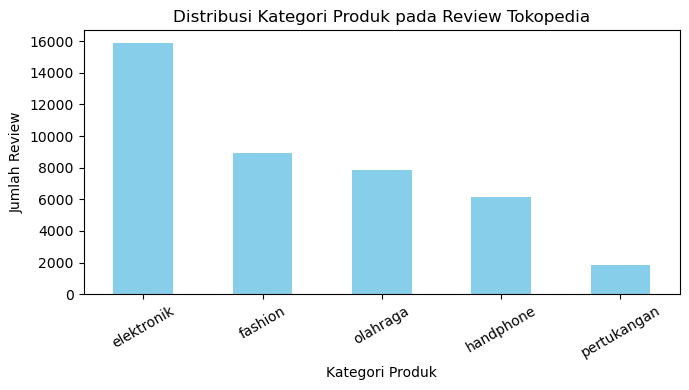

In [4]:
# Visualisasi distribusi kelas produk
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
df['category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribusi Kategori Produk pada Review Tokopedia')
plt.xlabel('Kategori Produk')
plt.ylabel('Jumlah Review')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## Statistik panjang teks (histogram)
Dapat dilihat bahwa berdasarkan histogram, paling banyak jumlah karakter per review ada pada range yang kurang dari 100.

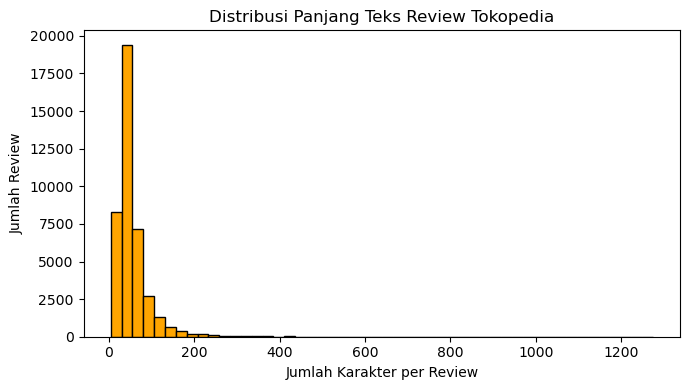

In [5]:
# Histogram panjang teks review
review_lengths = df['text'].str.len()
plt.figure(figsize=(7,4))
plt.hist(review_lengths, bins=50, color='orange', edgecolor='black')
plt.title('Distribusi Panjang Teks Review Tokopedia')
plt.xlabel('Jumlah Karakter per Review')
plt.ylabel('Jumlah Review')
plt.tight_layout()
plt.show()

## Frekuensi kata (top 20 kata)
Dapat dilihat bahwa kata yang paling sering muncul pada review Tokopedia adalah barang, diikuti oleh sesuai, cepat, dan, hingga diterima.

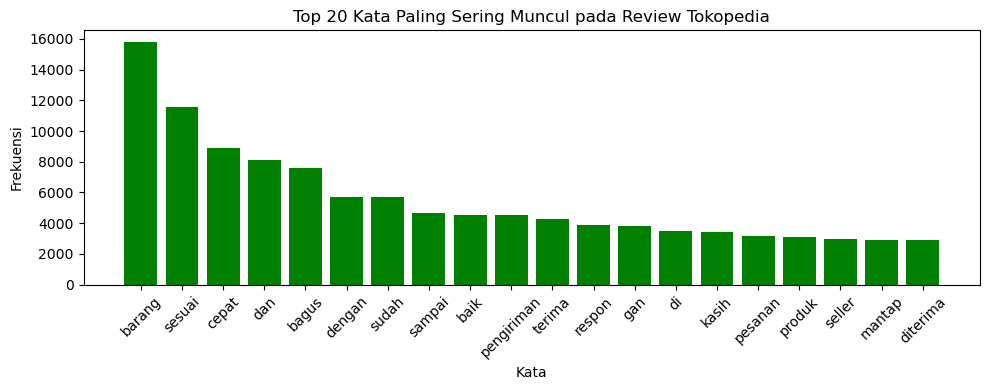

In [6]:
# Frekuensi kata (top 20 kata)
from collections import Counter
import re
all_text = ' '.join(df['text'].astype(str)).lower()
words = re.findall(r'\b\w+\b', all_text)
word_counts = Counter(words)
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)
plt.figure(figsize=(10,4))
plt.bar(words, counts, color='green')
plt.title('Top 20 Kata Paling Sering Muncul pada Review Tokopedia')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Text Pre-processing
Pada bagian **text pre-processing* saya akan melakukan beberapa hal, yaitu : 
- Pre-processing untuk karakter review,
- Lowercasing, hapus karakter khusus, dan tokenisasi,
- Stemming.

Disini saya melakukan pre-processing untuk menghapus review kosong, pendek, dan yang panjang untuk mengecek outlier bila karakternya banyak (tidak wajib diminta).

In [7]:
# hapus review kosong atau hanya whitespace
print('Jumlah review sebelum hapus kosong:', len(df))
df = df[df['text'].str.strip().astype(bool)]
print('Jumlah review setelah hapus kosong:', len(df))

# hapus review yang sangat pendek (misal: <5 karakter)
short_reviews = df[df['text'].str.len() < 5]
print('Jumlah review sangat pendek (<5 karakter):', len(short_reviews))
df = df[df['text'].str.len() >= 5]
print('Jumlah review setelah hapus sangat pendek:', len(df))

# hapus review yang sangat panjang (outlier, misal: >400 karakter)
long_reviews = df[df['text'].str.len() > 400]
print('Jumlah review sangat panjang (>400 karakter):', len(long_reviews))
df = df[df['text'].str.len() <= 400]
print('Jumlah review setelah hapus sangat panjang:', len(df))

Jumlah review sebelum hapus kosong: 40607
Jumlah review setelah hapus kosong: 40607
Jumlah review sangat pendek (<5 karakter): 0
Jumlah review setelah hapus sangat pendek: 40607
Jumlah review sangat panjang (>400 karakter): 73
Jumlah review setelah hapus sangat panjang: 40534


## 3.1 Preprocessing: lowercase, hapus karakter khusus, tokenisasi, stopwords, stemming/lemmatization

Menggunakan Sastrawi yang merupakan library python untuk text processing bahasa indonesia yang khusus untuk stopword removal kata-kata umum bahasa Indonesia

In [ ]:
import re
import string
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Inisialisasi stopword dan stemmer
stop_factory = StopWordRemoverFactory()
stopwords = set(stop_factory.get_stop_words())
stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Hapus angka dan karakter khusus
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # Tokenisasi
    tokens = text.split()
    # Hapus stopwords
    tokens = [t for t in tokens if t not in stopwords]
    # Stemming
    tokens = [stemmer.stem(t) for t in tokens]
    return ' '.join(tokens)

# Terapkan preprocessing ke seluruh review dan memberikan contoh sebagai visualisasi "sedikit"
print('Contoh sebelum preprocessing:', df['text'].iloc[0])
df['clean_text'] = df['text'].apply(preprocess_text)
print('Contoh sesudah preprocessing:', df['clean_text'].iloc[0])

Contoh sebelum preprocessing: Barang sesuai pesanan dan cepat sampai
Contoh sesudah preprocessing: barang sesuai pesan cepat
Contoh sesudah preprocessing: barang sesuai pesan cepat


# 4. Feature Representation
Pada tahap ini, saya akan mengubah teks yang sudah di pre-processing menjadi representasi numerik agar bisa digunakan untuk pelatihan model machine learning. Saya akan menggunakan : 
- TF-IDF,
- Count Verctorizer

In [14]:
# import TF-IDF dan CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Gunakan kolom hasil preprocessing yang tanpa stem
texts = df['clean_text_stopwords'] if 'clean_text_stopwords' in df.columns else df['clean_text']

# TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(texts)
print('Shape TF-IDF:', X_tfidf.shape)

# Count Vectorizer
count_vec = CountVectorizer(max_features=1000)
X_count = count_vec.fit_transform(texts)
print('Shape CountVectorizer:', X_count.shape)

Shape TF-IDF: (40534, 1000)
Shape CountVectorizer: (40534, 1000)
Shape CountVectorizer: (40534, 1000)


Dari hasil print, berarti ada sekitar 40534 reviews dan 1000 kata unik yang paling sering keluar (sudah di-max)

# 5. Model Training
Pada tahap ini, saya melatih 3 algoritma berbeda untuk klasifikasi teks. Algoritma yang saya gunakan adalah :
- Naive Bayes
- Logistic Regression
- Support Vector Machine (SVM)

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# fitur dan label
X = X_tfidf
y = df['category']

# split data ke train 80%, test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print('Naive Bayes Accuracy:', accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.47946219316639943
              precision    recall  f1-score   support

  elektronik       0.46      0.91      0.61      3168
     fashion       0.55      0.37      0.44      1758
   handphone       0.57      0.13      0.21      1231
    olahraga       0.45      0.12      0.20      1553
 pertukangan       0.91      0.03      0.05       397

    accuracy                           0.48      8107
   macro avg       0.59      0.31      0.30      8107
weighted avg       0.52      0.48      0.41      8107



In [24]:
# Logistic Regression
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print('Logistic Regression Accuracy:', accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.4827926483286049
              precision    recall  f1-score   support

  elektronik       0.49      0.82      0.61      3168
     fashion       0.52      0.39      0.45      1758
   handphone       0.50      0.17      0.25      1231
    olahraga       0.39      0.25      0.31      1553
 pertukangan       0.63      0.03      0.06       397

    accuracy                           0.48      8107
   macro avg       0.51      0.33      0.34      8107
weighted avg       0.49      0.48      0.44      8107



In [25]:
# SVM
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print('SVM Accuracy:', accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.47847539163685704
              precision    recall  f1-score   support

  elektronik       0.49      0.82      0.61      3168
     fashion       0.51      0.39      0.44      1758
   handphone       0.46      0.16      0.23      1231
    olahraga       0.39      0.25      0.31      1553
 pertukangan       0.62      0.04      0.08       397

    accuracy                           0.48      8107
   macro avg       0.49      0.33      0.33      8107
weighted avg       0.48      0.48      0.43      8107



# 6. Model Evaluation & Reporting
Pada bagian ini saya melakukan perbandingan dari metrik **accuracy, precision, recall, f1-score* dari model yang sudah dibuat pada poin sebelumnya. Kemudian, saya juga akan melakukan visualisasi dengan **confusion matrix heatmap* serta Bar Chart untuk mudah membandingkan hasilnya dengan visual.


Naive Bayes Classification Report:
              precision    recall  f1-score   support

  elektronik       0.46      0.91      0.61      3168
     fashion       0.55      0.37      0.44      1758
   handphone       0.57      0.13      0.21      1231
    olahraga       0.45      0.12      0.20      1553
 pertukangan       0.91      0.03      0.05       397

    accuracy                           0.48      8107
   macro avg       0.59      0.31      0.30      8107
weighted avg       0.52      0.48      0.41      8107



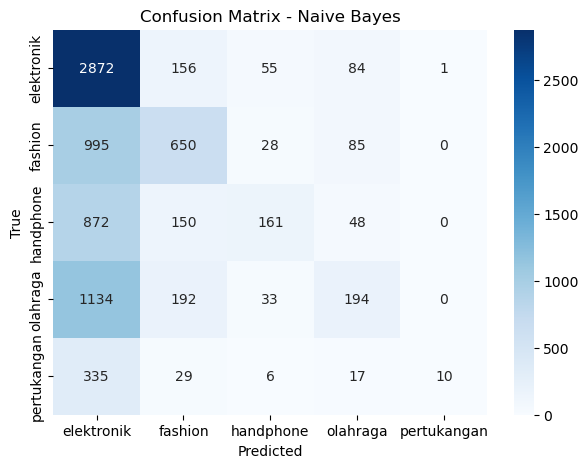


Logistic Regression Classification Report:
              precision    recall  f1-score   support

  elektronik       0.49      0.82      0.61      3168
     fashion       0.52      0.39      0.45      1758
   handphone       0.50      0.17      0.25      1231
    olahraga       0.39      0.25      0.31      1553
 pertukangan       0.63      0.03      0.06       397

    accuracy                           0.48      8107
   macro avg       0.51      0.33      0.34      8107
weighted avg       0.49      0.48      0.44      8107



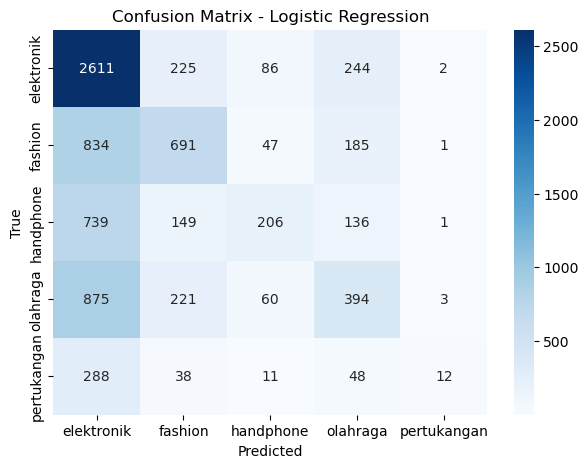


SVM Classification Report:
              precision    recall  f1-score   support

  elektronik       0.49      0.82      0.61      3168
     fashion       0.51      0.39      0.44      1758
   handphone       0.46      0.16      0.23      1231
    olahraga       0.39      0.25      0.31      1553
 pertukangan       0.62      0.04      0.08       397

    accuracy                           0.48      8107
   macro avg       0.49      0.33      0.33      8107
weighted avg       0.48      0.48      0.43      8107



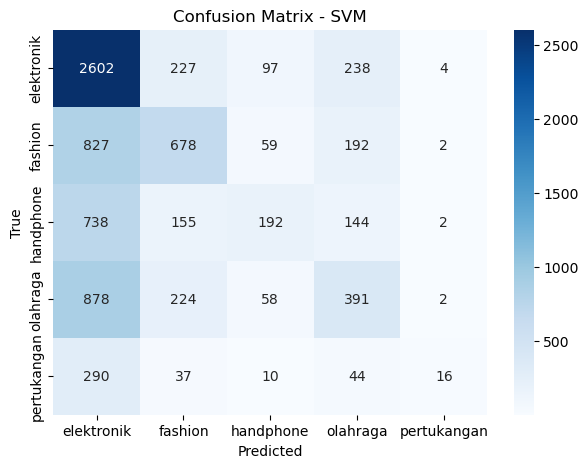

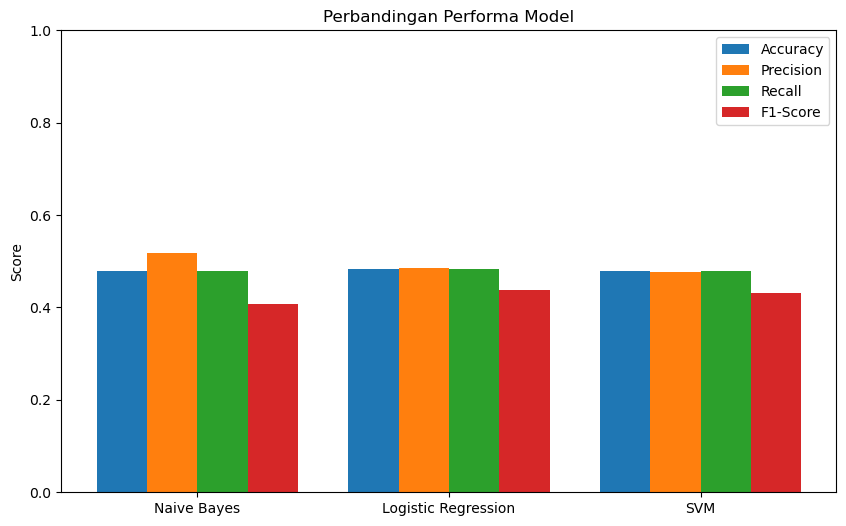

In [26]:
# Hitung metrik lengkap dan visualisasi untuk semua model
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

model_names = ['Naive Bayes', 'Logistic Regression', 'SVM']
predictions = [y_pred_nb, y_pred_lr, y_pred_svm]
metrics = []

for name, y_pred in zip(model_names, predictions):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    metrics.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1})
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    # Confusion matrix heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=nb.classes_, yticklabels=nb.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Bar chart perbandingan performa model
import numpy as np
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
bar_width = 0.2
x = np.arange(len(model_names))
plt.figure(figsize=(10,6))
for i, metric in enumerate(metric_names):
    plt.bar(x + i*bar_width, [m[metric] for m in metrics], width=bar_width, label=metric)
plt.xticks(x + bar_width*1.5, model_names)
plt.legend()
plt.title('Perbandingan Performa Model')
plt.ylabel('Score')
plt.ylim(0,1)
plt.show()

# Simpan hasil evaluasi ke CSV
import pandas as pd
evaluation_df = pd.DataFrame(metrics)
evaluation_df.to_csv('model_results.csv', index=False, encoding='utf-8')

Walaupun model yang dibangun belum sempurna (di bawah 50%), model bisa melakukan klasifikasi seperti pada review "barang bagus barang murah" labelnya adalah "olahraga" tapi predictednya "electronic".